**Table of contents**<a id='toc0_'></a>    
- 1. [General Information](#toc1_)    
- 2. [Imports](#toc2_)    
- 3. [Data Cleaning](#toc3_)    
  - 3.1. [Loading and Display](#toc3_1_)    
  - 3.2. [Cleaning String Data](#toc3_2_)    
  - 3.3. [Cleaning Numerical Data](#toc3_3_)    
- 4. [Data Preprocessing](#toc4_)    
  - 4.1. [Outlier Filtering](#toc4_1_)    
  - 4.2. [Pairplot and Insights](#toc4_2_)    
  - 4.3. [Preprocessing for `Name` Column](#toc4_3_)    
  - 4.4. [Preprocessing for `Domains` Column](#toc4_4_)    
  - 4.5. [Preprocessing for `Mechanics` Column (TODO?)](#toc4_5_)    
  - 4.6. [Correlation Heatmap and Insights](#toc4_6_)    
- 5. [Model Selection](#toc5_)    
  - 5.1. [Training and Test Data Split](#toc5_1_)    
  - 5.2. [LazyPredict](#toc5_2_)    
  - 5.3. [Grid Searches](#toc5_3_)    
    - 5.3.1. [RandomForestRegressor](#toc5_3_1_)    
    - 5.3.2. [CatBoost Regressor](#toc5_3_2_)    
    - 5.3.3. [LGBMRegressor](#toc5_3_3_)    
    - 5.3.4. [HistGradientBoostingRegressor](#toc5_3_4_)    
    - 5.3.5. [Weighted Average Model](#toc5_3_5_)    
  - 5.4. [Metrics and Weighted Average from Loaded Models](#toc5_4_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>[General Information](#toc0_)

__E02 -- Group 53 -- Question 34__

What makes a good board game? Which characteristics (playtime, number of players, complexity, genre) are most associated with higher ratings or popularity? Can the success of a board game be predicted based on its characteristics? Can we build a predictive model using features like genre, complexity, and playtime to predict a board game’s rating? What other factors affect the success of a board game? Do external factors like year of release, publisher reputation, or awards won impact success.

# 2. <a id='toc2_'></a>[Imports](#toc0_)

In [180]:
import numpy as np
import scipy as sp
import pandas as pd

import sklearn as sk
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.pipeline import make_pipeline

import lazypredict
from lazypredict.Supervised import LazyRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
#from catboost import CatBoostRegressor

import time
import typing
import re
import joblib
import lightgbm as lgb

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

plt.style.use('classic')

#plt.rcParams['mathtext.fontset'] = 'stix' # 'cm'
#plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 15
#plt.rcParams['xtick.labelsize'] = 15
#plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['figure.dpi'] = 100


In [181]:
SEED=42
np.random.seed(SEED)

# 3. <a id='toc3_'></a>[Data Cleaning](#toc0_)

## 3.1. <a id='toc3_1_'></a>[Loading and Display](#toc0_)

First we load the data set by reading the `csv` file and store it in a `pandas.DataFrame` data structure.

After loading we take a look at the current state of the data set via `df.info()` and `df.head()`. We see that we have `20343` data points, consisting both of numerical and string data.

In [182]:
# Load data set
df = pd.read_csv("data/bgg_dataset.csv", sep=";")

# Display current data set
display(df.info())
display(df.describe())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20343 entries, 0 to 20342
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  20327 non-null  float64
 1   Name                20343 non-null  object 
 2   Year Published      20342 non-null  float64
 3   Min Players         20343 non-null  int64  
 4   Max Players         20343 non-null  int64  
 5   Play Time           20343 non-null  int64  
 6   Min Age             20343 non-null  int64  
 7   Users Rated         20343 non-null  int64  
 8   Rating Average      20343 non-null  object 
 9   BGG Rank            20343 non-null  int64  
 10  Complexity Average  20343 non-null  object 
 11  Owned Users         20320 non-null  float64
 12  Mechanics           18745 non-null  object 
 13  Domains             10184 non-null  object 
dtypes: float64(3), int64(6), object(5)
memory usage: 2.2+ MB


None

,ID,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,BGG Rank,Owned Users
count,20327.00,20342.00,20343.00,20343.00,20343.00,20343.00,20343.00,20343.00,20320.00
mean,108216.25,1984.25,2.02,5.67,91.29,9.60,840.97,10172.89,1408.46
std,98682.10,214.00,0.69,15.23,545.45,3.65,3511.56,5872.83,5040.18
min,1.00,-3500.00,0.00,0.00,0.00,0.00,30.00,1.00,0.00
25%,11029.00,2001.00,2.00,4.00,30.00,8.00,55.00,5087.50,146.00
50%,88931.00,2011.00,2.00,4.00,45.00,10.00,120.00,10173.00,309.00
75%,192939.50,2016.00,2.00,6.00,90.00,12.00,385.00,15258.50,864.00
max,331787.00,2022.00,10.00,999.00,60000.00,25.00,102214.00,20344.00,155312.00


,ID,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains
0,174430.00,Gloomhaven,2017.00,1,4,120,14,42055,"8,79",1,"3,86",68323.00,"Action Queue, Action Retrieval, Campaign / Bat...","Strategy Games, Thematic Games"
1,161936.00,Pandemic Legacy: Season 1,2015.00,2,4,60,13,41643,"8,61",2,"2,84",65294.00,"Action Points, Cooperative Game, Hand Manageme...","Strategy Games, Thematic Games"
2,224517.00,Brass: Birmingham,2018.00,2,4,120,14,19217,"8,66",3,"3,91",28785.00,"Hand Management, Income, Loans, Market, Networ...",Strategy Games
3,167791.00,Terraforming Mars,2016.00,1,5,120,12,64864,"8,43",4,"3,24",87099.00,"Card Drafting, Drafting, End Game Bonuses, Han...",Strategy Games
4,233078.00,Twilight Imperium: Fourth Edition,2017.00,3,6,480,14,13468,"8,70",5,"4,22",16831.00,"Action Drafting, Area Majority / Influence, Ar...","Strategy Games, Thematic Games"


## 3.2. <a id='toc3_2_'></a>[Cleaning String Data](#toc0_)

First let's work on the string data columns `Name`, `Mechanics` and `Domains`. While `Name` has no values missing, the other two are quite vacant with thousands of values missing.

Therefore, it is not a good strategy to just drop all rows with missing values. Rather, we set the content of these rows to the string "Unknown", which permits us to use the other data.

In [183]:
# Print number of missing values for all columns
print(df.isna().sum())

# Set missing values to "Unknown"
df.loc[df['Mechanics'].isna(), "Mechanics"] = "Unknown"
df.loc[df['Domains'].isna(), "Domains"] = "Unknown"

ID                       16
Name                      0
Year Published            1
Min Players               0
Max Players               0
Play Time                 0
Min Age                   0
Users Rated               0
Rating Average            0
BGG Rank                  0
Complexity Average        0
Owned Users              23
Mechanics              1598
Domains               10159
dtype: int64


## 3.3. <a id='toc3_3_'></a>[Cleaning Numerical Data](#toc0_)

Now, we clean the numerical data.

As seen in the above data stats, the number of missing values for the numerical columns in neglectable. Therefore we drop all remaining rows with missing values.


The columns `ID` (unique board game ID, redundant to built-in `DataFrame` index variable) and `BGG Rank` (rank of board game, redundant to `Rating Average`) do not really contain any useful information for us. Therefore we can drop both columns.


The `Year Published` and `Owned Users` columns are stored in a `float64` format, which is not appropriate.
We convert both of them to `int64`.


The `Rating Average` and `Complexity Average` columns use the comma as the decimal point. This notation that is not usable for `Python`, therefore we replace all commas with dots.

In [184]:
# Drop all rows with missing numerical values
df.dropna(inplace=True)

# Drop ID column from the DataFrame
df.drop("ID", axis=1, inplace=True)
df.drop("BGG Rank", axis=1, inplace=True)

# Convert float columns to int
df["Year Published"] = df["Year Published"].astype(int)
df["Owned Users"] = df["Owned Users"].astype(int)

### Replace all negative years with zero (not used currently)
### df.loc[df["Year Published"] < 0, "Year Published"] = 0

# Replace commas with dots.
df["Rating Average"] = df["Rating Average"].str.replace(",", ".").astype(float)
df["Complexity Average"] = df["Complexity Average"].str.replace(",", ".").astype(float)

In [185]:
# Now, missing data does not necessarily mean empty or nan but it is rather the lack of information,
# For example, in the columns ['Min Players', 'Max Players', 'Play Time', 'Min Age', 'Owned Users']
# The minimum value is "0" and that right there is meaningless information because it simply can't be.
columns_to_check = ['Min Players', 'Max Players', 'Play Time', 'Min Age', 'Owned Users']
for col in columns_to_check:
  count = (df[col] == 0).sum()
  print(f"Occurrences of Zero in {col}: {count}")


# We can drop those for rows for now.
# Drop rows where the value appears in any of the specified columns
df = df[~df[columns_to_check].isin([0]).any(axis=1)]

Occurrences of Zero in Min Players: 46
Occurrences of Zero in Max Players: 161
Occurrences of Zero in Play Time: 554
Occurrences of Zero in Min Age: 1250
Occurrences of Zero in Owned Users: 1


In [186]:
# To make good use of both the 'Owned Users' and the 'Users Rated'
# We can create a new column 'Owned% Rated' and then we can use increments of 10% for visualization.
# First, we have to make sure that all the instances of 'Owned Users' > 'Users Rated' and drop these that don't satisfy this condition.

df = df[df['Users Rated'] < df['Owned Users']]
df['Owned% Rated'] = (df['Users Rated']/df['Owned Users'])*100

In [187]:
df.reset_index(drop=True, inplace=True)

In [188]:
# Take a copy, just in case we add new columns
df_org = df.copy()

In [189]:
# Display current data set
display(df_org.info())
display(df_org.describe())
display(df_org.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18090 entries, 0 to 18089
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                18090 non-null  object 
 1   Year Published      18090 non-null  int64  
 2   Min Players         18090 non-null  int64  
 3   Max Players         18090 non-null  int64  
 4   Play Time           18090 non-null  int64  
 5   Min Age             18090 non-null  int64  
 6   Users Rated         18090 non-null  int64  
 7   Rating Average      18090 non-null  float64
 8   Complexity Average  18090 non-null  float64
 9   Owned Users         18090 non-null  int64  
 10  Mechanics           18090 non-null  object 
 11  Domains             18090 non-null  object 
 12  Owned% Rated        18090 non-null  float64
dtypes: float64(3), int64(7), object(3)
memory usage: 1.8+ MB


None

,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,Complexity Average,Owned Users,Owned% Rated
count,18090.00,18090.00,18090.00,18090.00,18090.00,18090.00,18090.00,18090.00,18090.00,18090.00
mean,1994.48,2.03,5.77,89.11,10.25,903.42,6.40,1.98,1526.55,46.65
std,160.33,0.68,15.80,551.34,2.77,3680.18,0.90,0.83,5305.51,17.38
min,-3500.00,1.00,1.00,1.00,1.00,30.00,1.90,0.00,32.00,2.00
25%,2001.00,2.00,4.00,30.00,8.00,60.00,5.83,1.33,160.00,33.96
50%,2011.00,2.00,4.00,45.00,10.00,135.00,6.42,1.94,347.00,44.58
75%,2016.00,2.00,6.00,90.00,12.00,433.75,7.00,2.50,966.00,57.41
max,2022.00,10.00,999.00,60000.00,25.00,102214.00,9.46,5.00,155312.00,99.72


,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,Complexity Average,Owned Users,Mechanics,Domains,Owned% Rated
0,Gloomhaven,2017,1,4,120,14,42055,8.79,3.86,68323,"Action Queue, Action Retrieval, Campaign / Bat...","Strategy Games, Thematic Games",61.55
1,Pandemic Legacy: Season 1,2015,2,4,60,13,41643,8.61,2.84,65294,"Action Points, Cooperative Game, Hand Manageme...","Strategy Games, Thematic Games",63.78
2,Brass: Birmingham,2018,2,4,120,14,19217,8.66,3.91,28785,"Hand Management, Income, Loans, Market, Networ...",Strategy Games,66.76
3,Terraforming Mars,2016,1,5,120,12,64864,8.43,3.24,87099,"Card Drafting, Drafting, End Game Bonuses, Han...",Strategy Games,74.47
4,Twilight Imperium: Fourth Edition,2017,3,6,480,14,13468,8.70,4.22,16831,"Action Drafting, Area Majority / Influence, Ar...","Strategy Games, Thematic Games",80.02


# 4. <a id='toc4_'></a>[Data Preprocessing](#toc0_)

## 4.1. <a id='toc4_1_'></a>[Outlier Filtering](#toc0_)

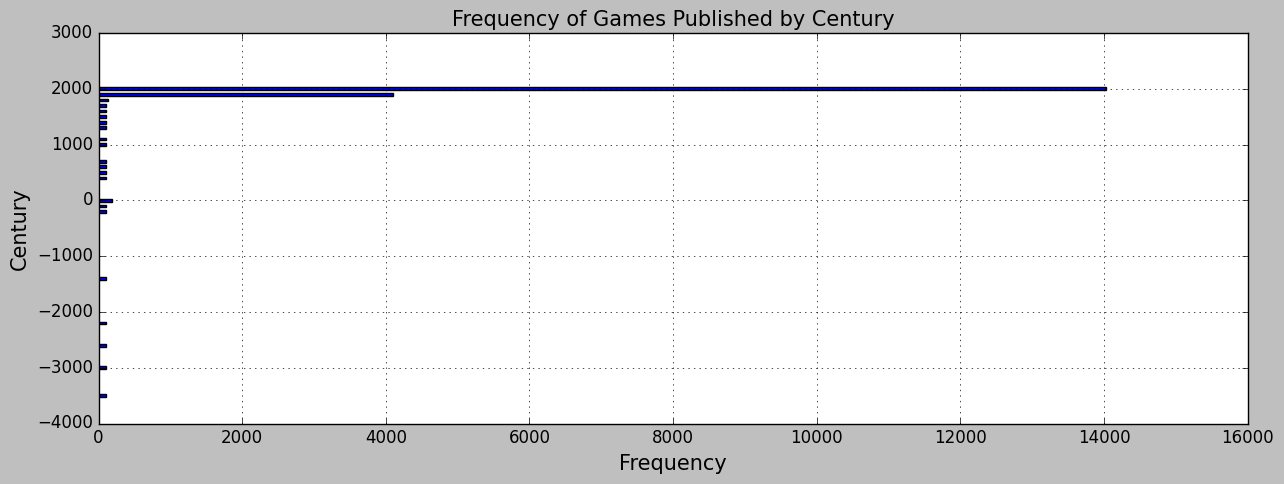

In [190]:
# Let's check "When did we start to really make games?"
def categorize_year(year):
    if pd.isna(year):
        return None  # Handle missing values
    else:
        return int((year // 100) * 100)

# Apply the categorization function to the 'Year Published' column
df['Century'] = df['Year Published'].apply(categorize_year)

# Count the occurrences of each century
century_counts = df['Century'].value_counts().sort_index()

# Create a barh plot
plt.figure(figsize=(13, 5))
plt.barh(y=century_counts.index,
         width=century_counts+100,# adding a flat value to show all the very small occurrences
         height=50,
         align='center',
)

# Plot Customization
plt.xlabel('Frequency')
plt.ylabel('Century')
plt.title('Frequency of Games Published by Century')
plt.grid();plt.tight_layout()
plt.show()

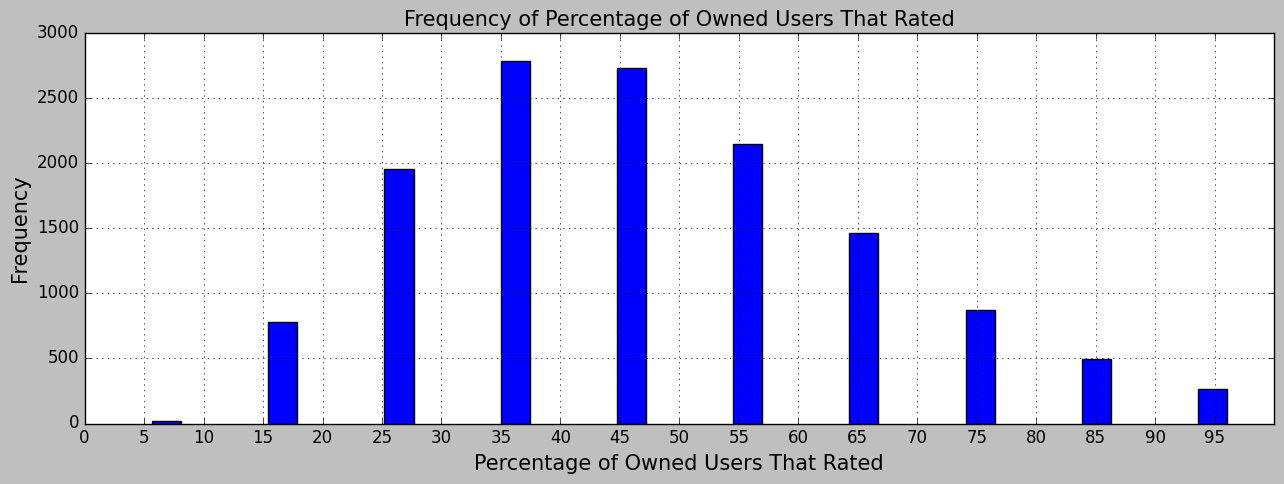

In [191]:
# Let's see the Percentage of Owned Users That Rated?
owned_p_rated = df['Owned% Rated'].value_counts().sort_index()

# Create a bar plot
fig, ax = plt.subplots(figsize=(13, 5))
plt.hist(x=owned_p_rated.index,
         bins=10,
         rwidth=0.25,
)

# Plot Customization
plt.xticks(np.arange(0 ,100, 5))
plt.ylabel('Frequency')
plt.xlabel('Percentage of Owned Users That Rated')
plt.title('Frequency of Percentage of Owned Users That Rated')
plt.grid();plt.tight_layout()
plt.show()

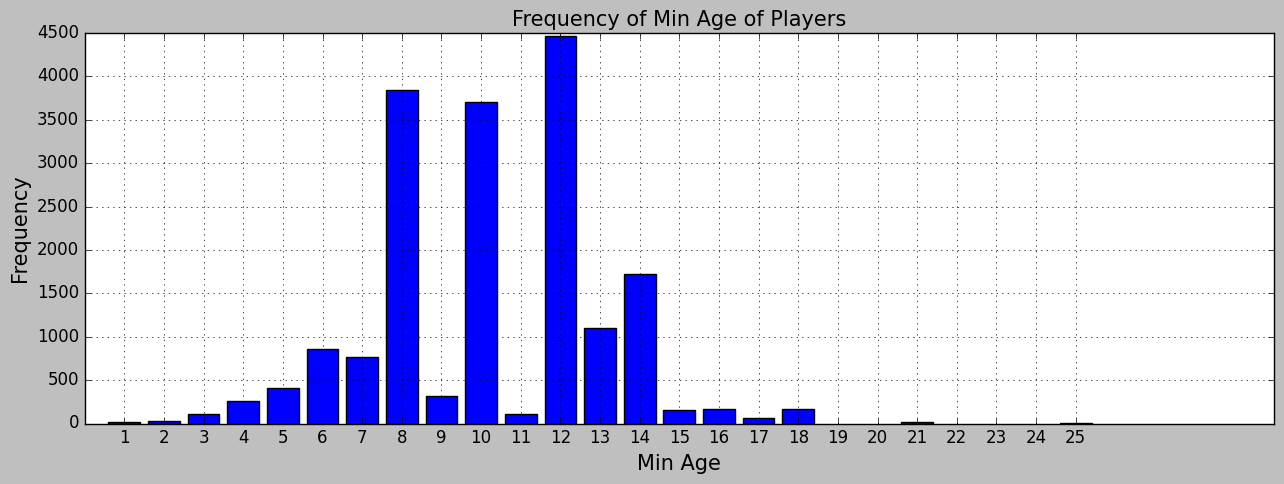

In [192]:
# Let's see the minimum age of players?
min_age = df['Min Age'].value_counts().sort_index()

# Create a bar plot
fig, ax = plt.subplots(figsize=(13, 5))
plt.bar(x=min_age.index,
         height=min_age+10,# adding a flat value to show all the very small occurrences
         align='center',
)

# Plot Customization
plt.xticks(np.arange(min(min_age.index), max(min_age.index)+1, 1))
plt.ylabel('Frequency')
plt.xlabel('Min Age')
plt.title('Frequency of Min Age of Players')
plt.grid();plt.tight_layout()
plt.show()

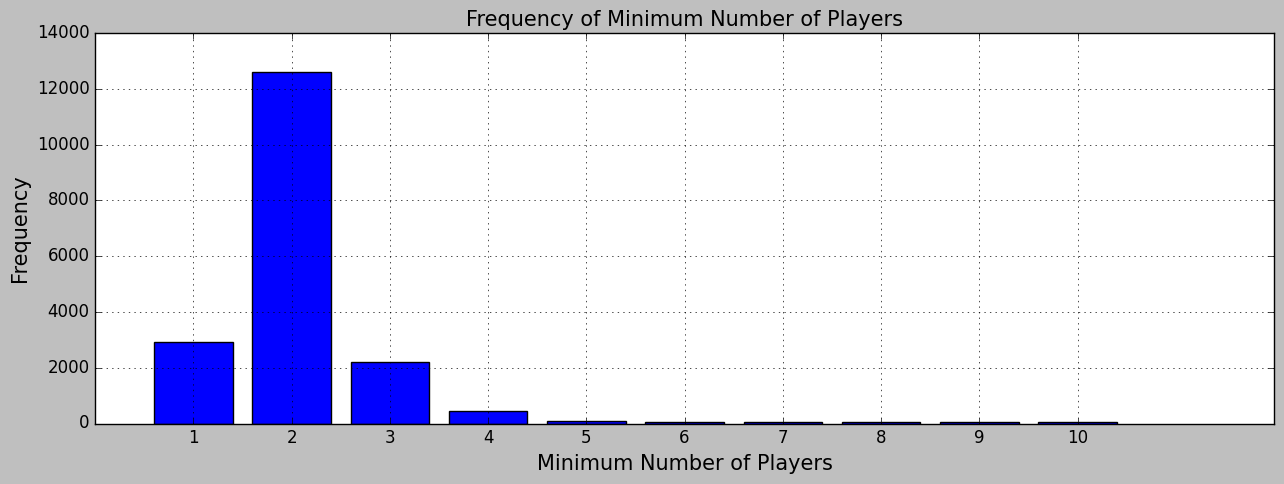

In [193]:
# Let's see the minimum number of players?
min_players = df['Min Players'].value_counts().sort_index()

# Create a bar plot
fig, ax = plt.subplots(figsize=(13, 5))
plt.bar(x=min_players.index,
         height=min_players+50,# adding a flat value to show all the very small occurrences
         align='center',
)

# Plot Customization
plt.xticks(np.arange(min(min_players.index), max(min_players.index)+1, 1))
plt.ylabel('Frequency')
plt.xlabel('Minimum Number of Players')
plt.title('Frequency of Minimum Number of Players')
plt.grid();plt.tight_layout()
plt.show()

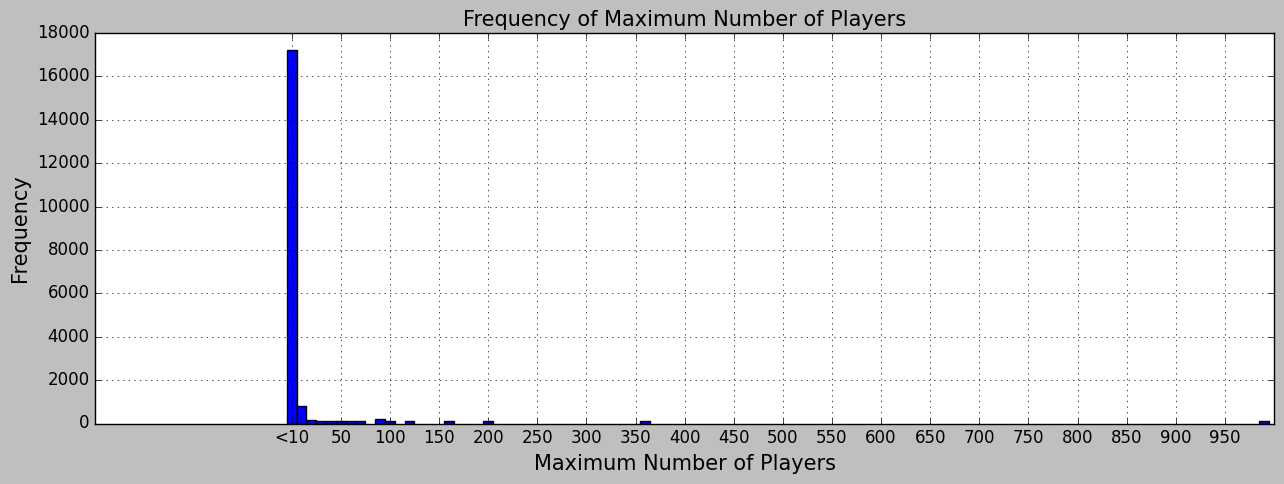

In [194]:
# Let's check the max players as well but in increments of 10 players
def categorize_max_players(max_players):
    if pd.isna(max_players):
        return None  # Handle missing values
    else:
        return (max_players // 10) * 10

# Apply the categorization function to the 'Max Players' column
df_tens = df['Max Players'].apply(categorize_max_players)

# Count the occurrences
max_players = df_tens.value_counts().sort_index()

# Create a bar plot
fig, ax = plt.subplots(figsize=(13, 5))
plt.bar(x=max_players.index,
         height=max_players+100,# adding a flat value to show all the very small occurrences
         width=10,
         align='center',
)

# Plot Customization
plt.xticks(np.arange(min(max_players.index), max(max_players.index)+10, 50))
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = '<10'
ax.set_xticklabels(labels)
plt.ylabel('Frequency')
plt.xlabel('Maximum Number of Players')
plt.title('Frequency of Maximum Number of Players')
plt.grid();plt.tight_layout()
plt.show()

Now, let's be real here,
board games are for... at max 20 players, any more and it is more of a carpet game and less of a board game. What board fits 999 players?

In [195]:
# We should drop these rows
df.drop(df[df['Max Players'] > 20].index, inplace=True)
df.reset_index(drop=True, inplace=True)

Adding more engineered features can enhance the analysis and model performance
let's add the number of average players, and the Players range.

In [196]:
df['Avg Players'] = (df['Min Players'] + df['Max Players']) / 2
df['Avg Players'] = df['Avg Players'].round().astype(int)
df['Player Range'] = df['Max Players'] - df['Min Players']

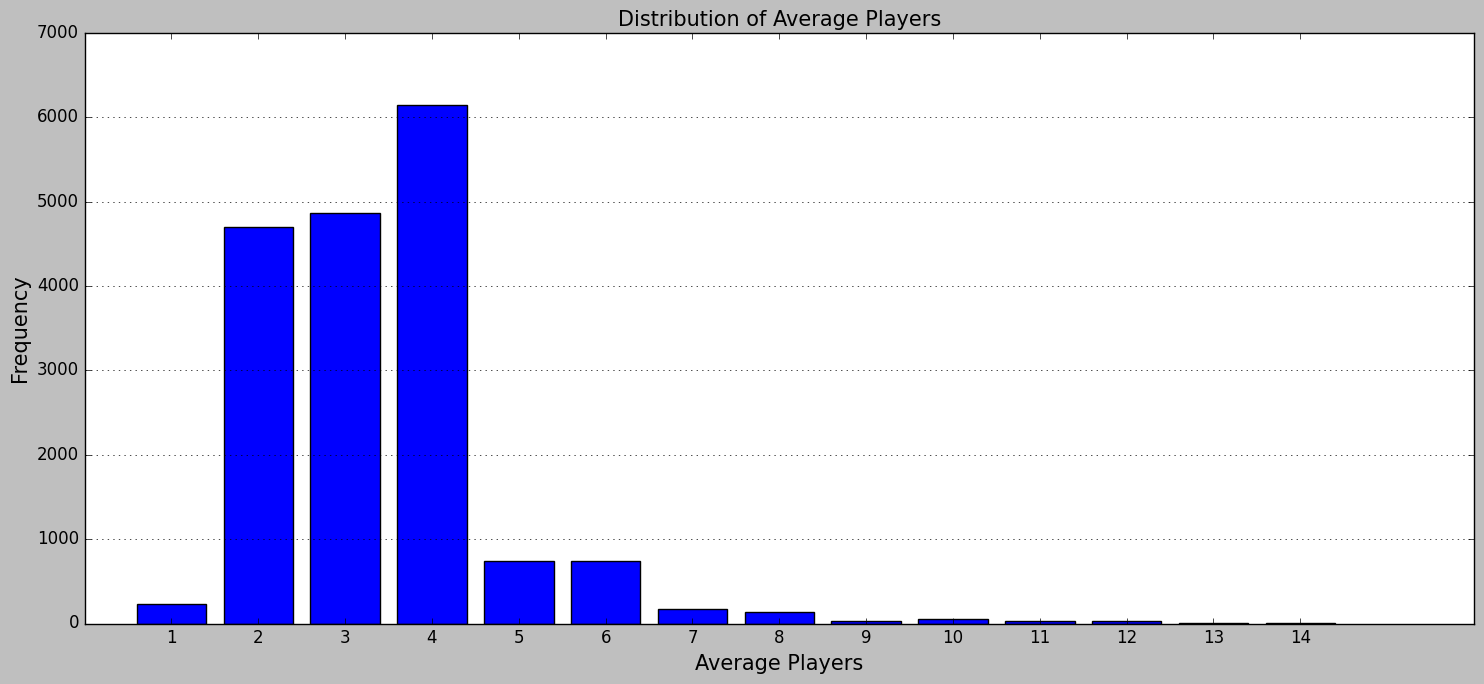

In [197]:
player_counts = df['Avg Players'].value_counts().sort_index()

# Zoom in on the x-axis where most values are around one
zoomed_counts = player_counts[player_counts.index <= 25]

plt.figure(figsize=(15, 7))
plt.bar(zoomed_counts.index, zoomed_counts.values, color='blue')

# Plot Customization
plt.xlabel('Average Players')
plt.ylabel('Frequency')
plt.title('Distribution of Average Players')
plt.xticks(zoomed_counts.index)  
plt.grid(axis='y')
plt.tight_layout()
plt.show()

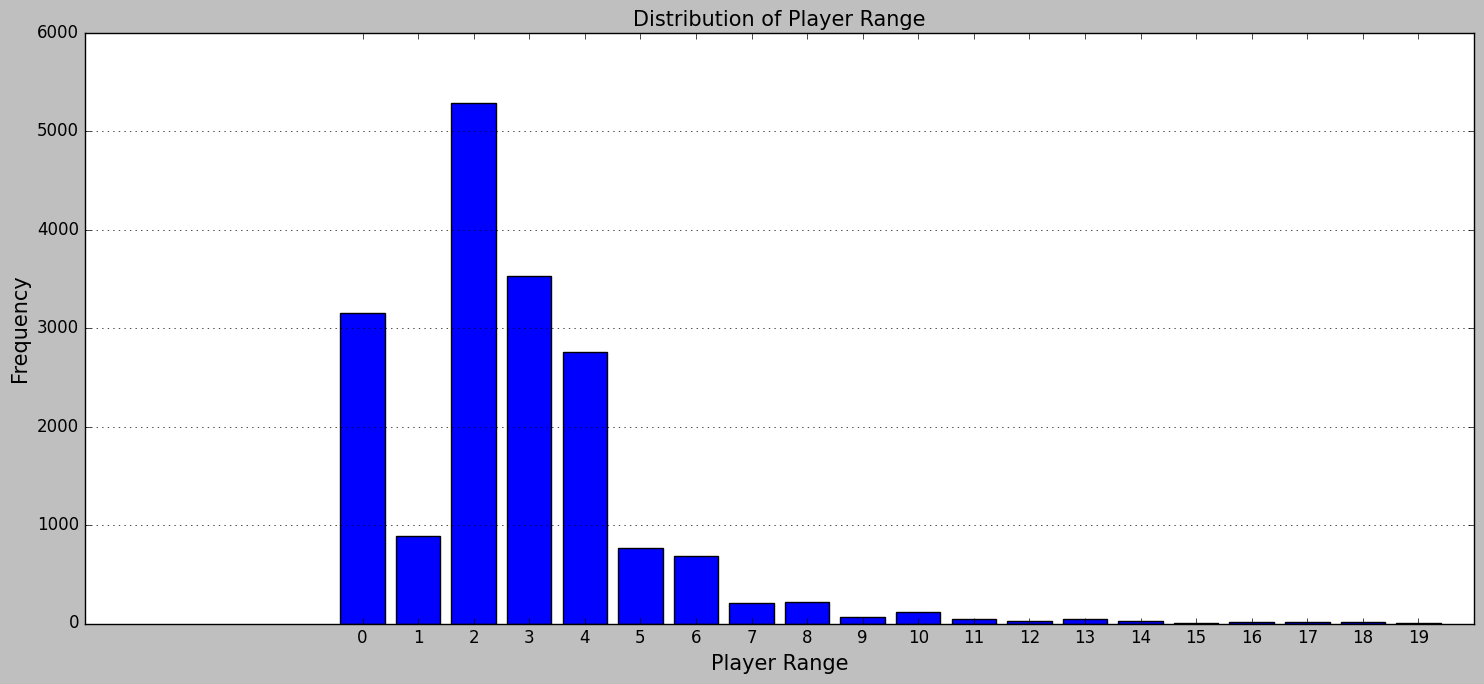

In [198]:
player_range_counts = df['Player Range'].value_counts().sort_index()

# Zoom in on the x-axis where most values are around one
zoomed_range_counts = player_range_counts[player_range_counts.index <= 25]

plt.figure(figsize=(15, 7))
plt.bar(zoomed_range_counts.index, zoomed_range_counts.values, color='blue')

# Plot Customization
plt.xlabel('Player Range')
plt.ylabel('Frequency')
plt.title('Distribution of Player Range')
plt.xticks(zoomed_range_counts.index)  
plt.grid(axis='y')
plt.tight_layout()
plt.show()

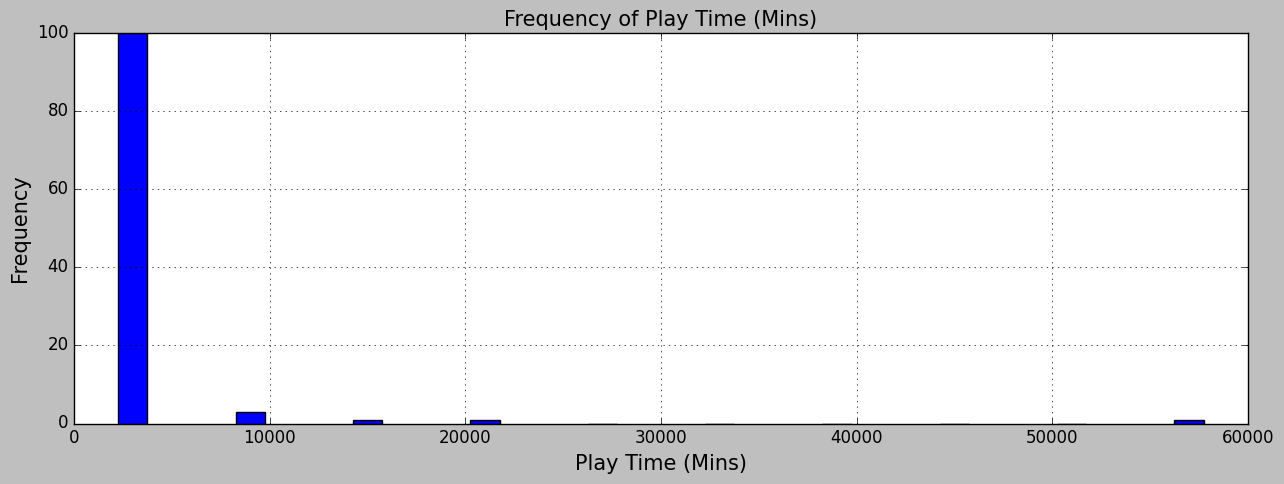

In [199]:
# Let's see the 'Play Time'?
play_time = df['Play Time'].value_counts().sort_index()

# Create a bar plot
fig, ax = plt.subplots(figsize=(13, 5))
plt.hist(x=play_time.index,
         bins=10,
         rwidth=0.25,
)

# Plot Customization
plt.ylabel('Frequency')
plt.xlabel('Play Time (Mins)')
plt.title('Frequency of Play Time (Mins)')
plt.grid();plt.tight_layout()
plt.show()

What kind of games take this long to play?

Let's say that a reasonable game session is about 6 hours, for example DnD games could take a lot more but they are played across multiple sessions and not in one go.

In [200]:
# We should drop these rows
df.drop(df[df['Play Time'] > 360].index, inplace=True)
df.reset_index(drop=True, inplace=True)

## 4.2. <a id='toc4_2_'></a>[Pairplot and Insights](#toc0_)

<Figure size 2100x1300 with 0 Axes>

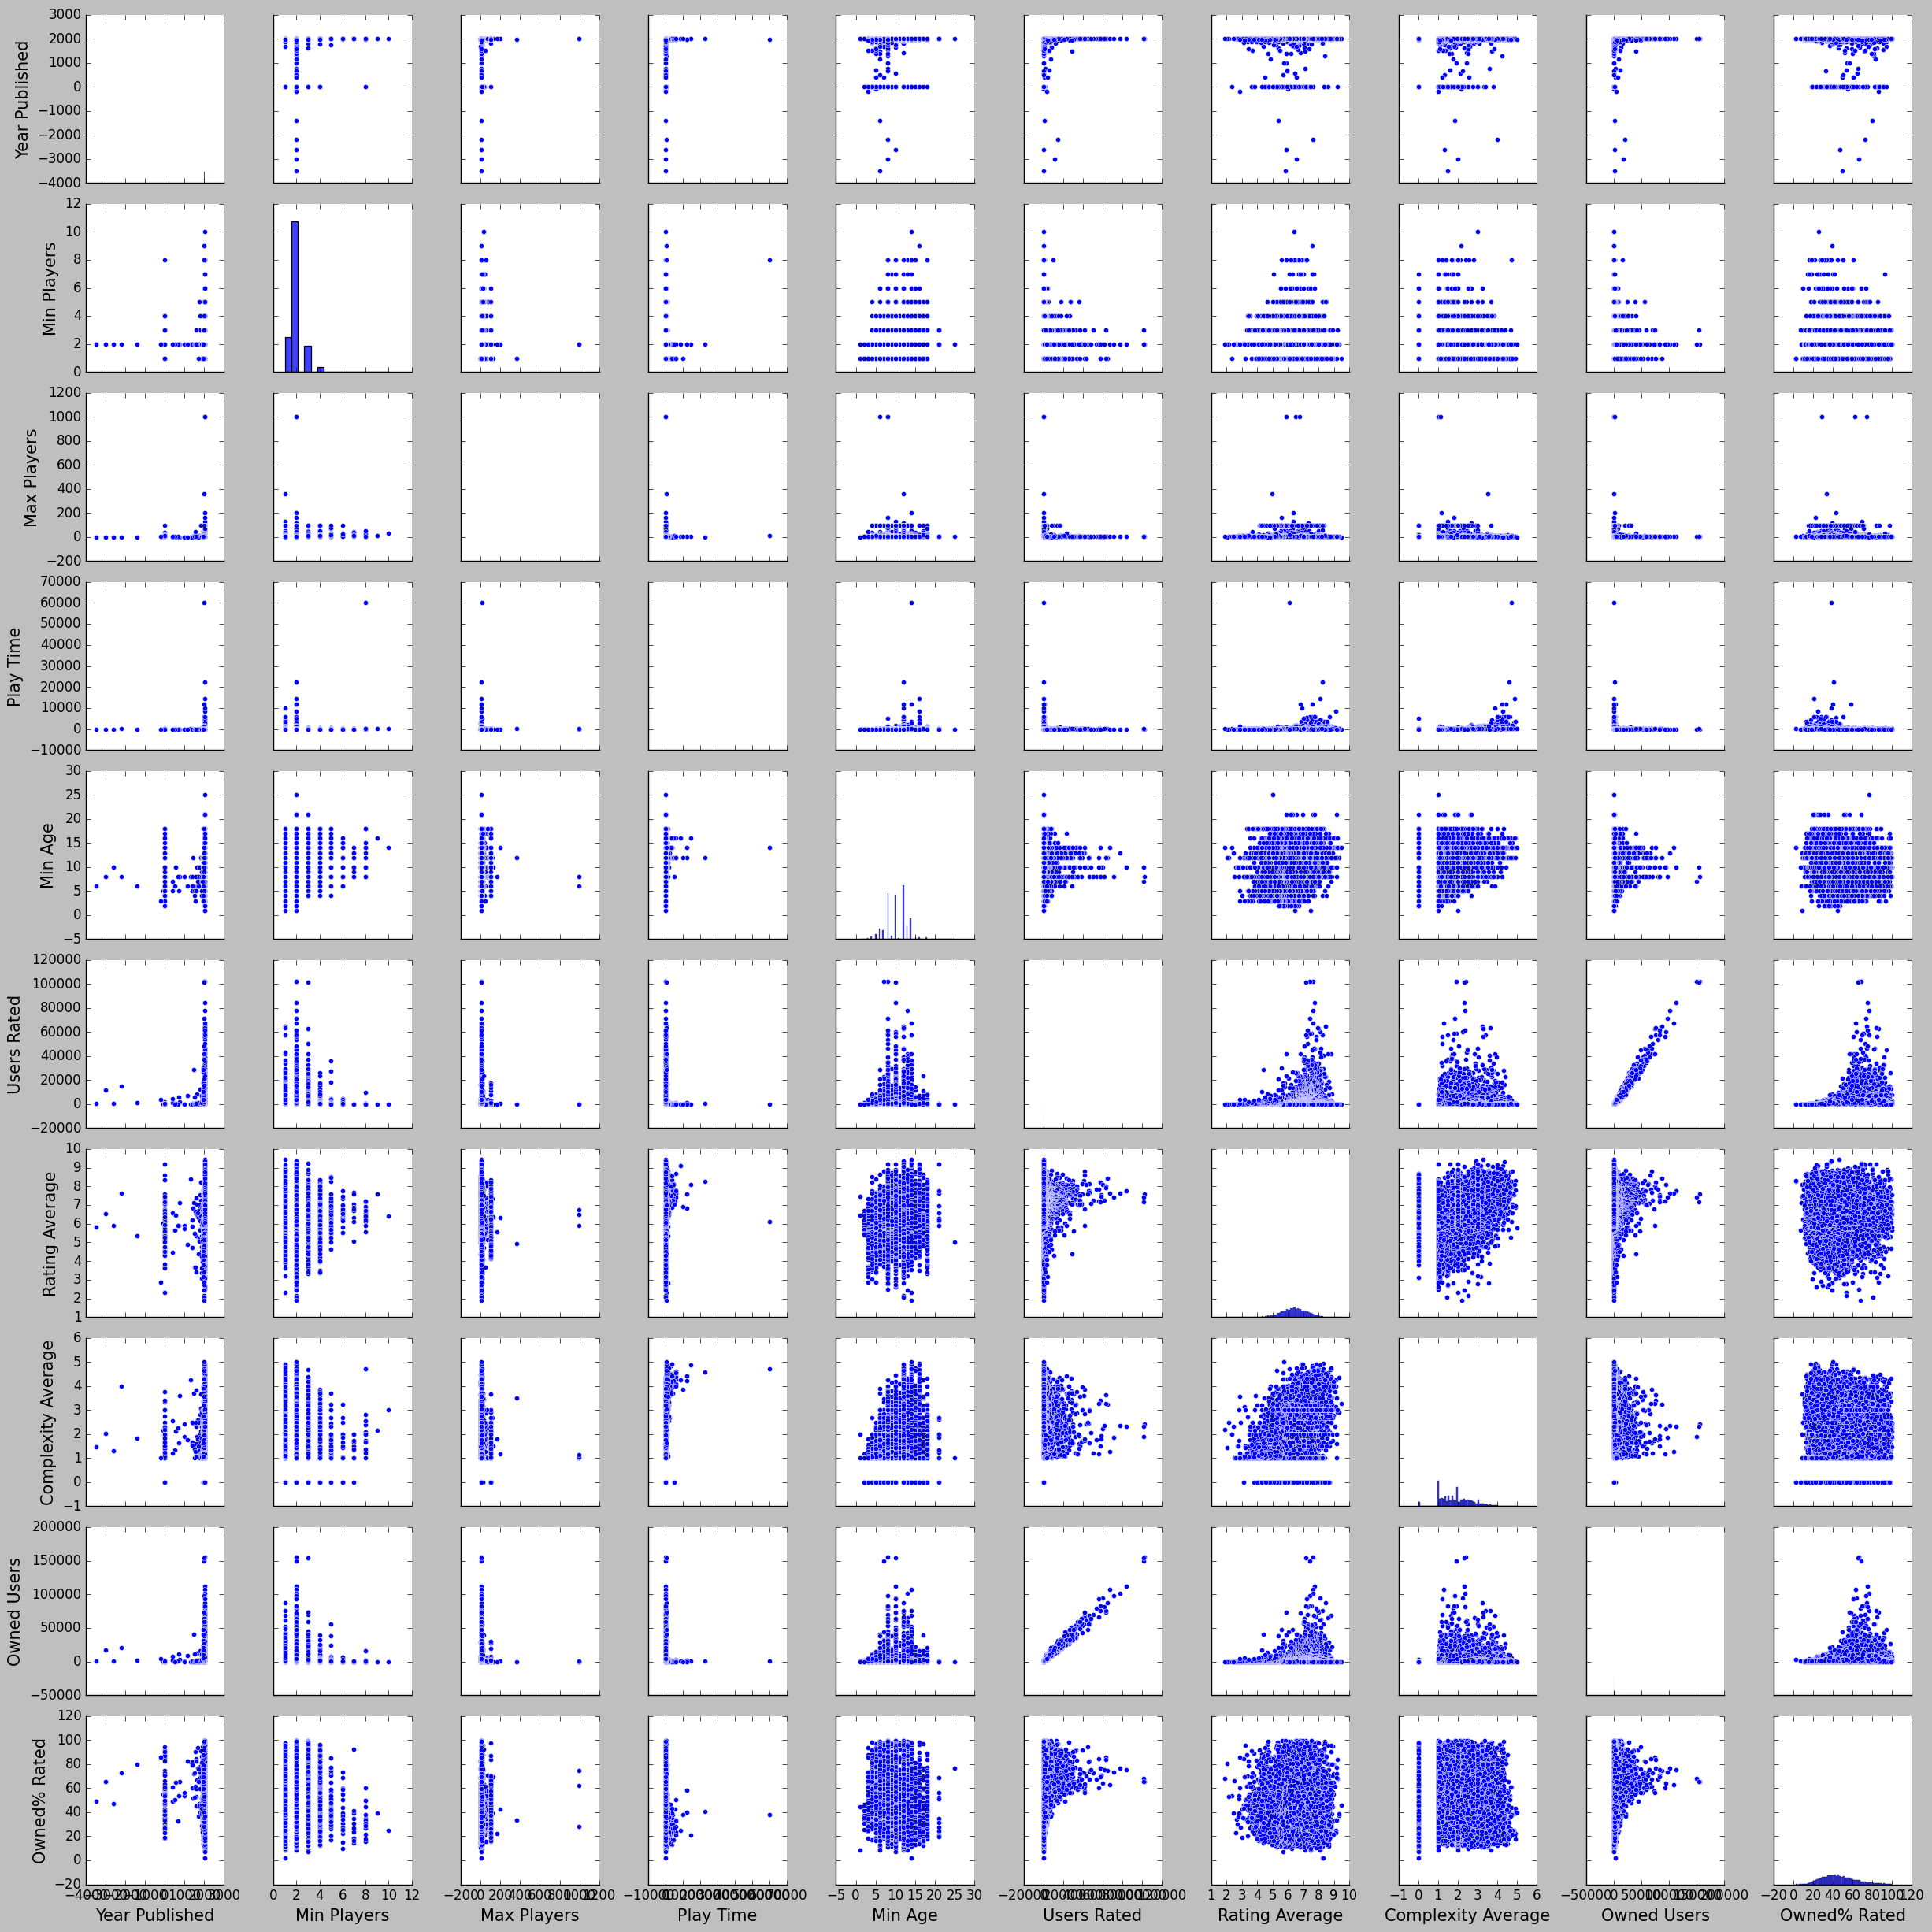

In [201]:
# A data exploration section can not be complete without a disturbing pairplot
columns = list(df_org.select_dtypes(include=['int64', 'float64']).columns)[:10] # Get the original first 10 columns
plt.figure(figsize=(21, 13))
sns.pairplot(df_org[columns])

***Interesting Insight***

- **(Year Published & Rating Average)**
 Although there are multiple outliers in the `Year Published` yet it is still informative as there is a correlation with the complexity of the game and its time period as we will see in the correlation heatmap.

 So, the outliers still provide us with some information about a "what is a good board game" as it seems that the answer is affected by the time period.

In [202]:
def clean_string(s):
    """
    Custom function for cleaning the words before frequancy analysis.
    """
    s = re.sub('[^a-zA-Z], ,', ' ',str(s).replace('Unknown','')
                                      .replace('\'s','')
                                      .replace('games','')
                                      .replace('Games','')
                                      .replace('/',',')
    )

    return s

## 4.3. <a id='toc4_3_'></a>[Preprocessing for `Name` Column](#toc0_)

In [203]:
def clean_and_encode(row, word_freqs):
  """
  Cleans a string, then calculates how "unique" it is:
    We want this score to be increasing, meaning more is better.
    So, we go for 1 - X
    Now, X is dependent on two things:
        - the number of words
        - the frequancy of each word
    If the word does not have a frequency then it gets a value of 1/num_of_words,
    in this way any name with weird words gets a score of zero, still informative to some degree.

  Args:
      row: A single row from the DataFrame.
      word_freqs: A dict of English word frequency(normalized).

  Returns:
      A float from 0 to 1 indicating how unique a name is.
  """

  words = re.sub(r"[^\w\s]", "", row).lower().split()
  X = [word_freqs.get(word, 1/len(words)) for word in words]
  score = 1 - sum(X)
  return score

# Data_Source: https://www.kaggle.com/datasets/rtatman/english-word-frequency?resource=download
word_frequencies = pd.read_csv("data/unigram_freq.csv")

# Normalize the frequancies
scaler = MinMaxScaler()
word_frequencies['count'] = scaler.fit_transform(word_frequencies[['count']])

# Turn the frequancies into a dict
word_frequencies_dict = dict(zip(word_frequencies['word'], word_frequencies['count']))

# Calculate the uniqueness score for the game names
df["Name Uniqueness"] = df["Name"].apply(clean_and_encode, args=(word_frequencies_dict,))

## 4.4. <a id='toc4_4_'></a>[Preprocessing for `Domains` Column](#toc0_)

{'War': 1.0, 'Strategy': 0.7715023994093761, 'Family': 0.7633813215208564, 'Thematic': 0.4141749723145072, 'Abstract': 0.3266888150609081, 'Children': 0.29346622369878184, 'Party': 0.21040974529346623, 'Customizable': 0.09892949427833149}


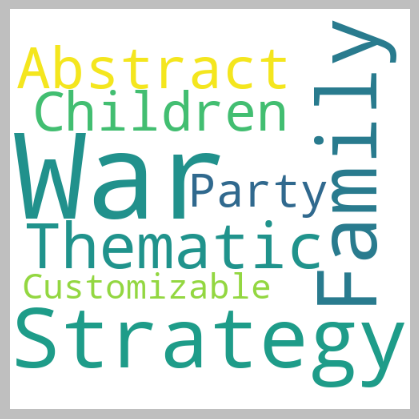

In [204]:
# Let's visualize the domains
# Concatenate all words into a single string
df_domains_words = df_org['Domains'].apply(clean_string)

# The Domain "War" has many different forms so after cleaning it still needs some preprocessing to get it ready for the word cloud plot.
all_words = ''.join(df_domains_words.str.cat(sep='')).replace('War','War,').replace('War ','War,').replace(' War',',War')

# Create a WordCloud object
wordcloud = WordCloud(width=500, height=500, background_color='white', collocations=False, min_font_size=2, font_step=0.5).generate(all_words)
print(wordcloud.words_)

# Display the generated image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [205]:
# Since there are 8 domains, we can turn the domain column into 8 domain columns
def split_and_encode(row, possible_domains):
    """
    Splits a string, checks for the presence of possible domains,
    and creates a list for one-hot encoding.

    Args:
        row: A single row from the DataFrame.
        possible_domains: A list of possible domains in the string.

    Returns:
        A list of 0s and 1s indicating the presence of each possible domain.
    """

    return [(1 if word.lower() in row.lower() else 0) for word in possible_domains]

# Define the domain words
possible_domains = ['war', 'strategy', 'family', 'thematic', 'abstract', 'children', 'party', 'customizable']

df_domains = pd.DataFrame(df['Domains'].apply(split_and_encode, args=(possible_domains,)).to_list(),
                     columns=possible_domains)

df = pd.concat([df, df_domains], axis=1)

In [206]:
display(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17652 entries, 0 to 17651
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                17652 non-null  object 
 1   Year Published      17652 non-null  int64  
 2   Min Players         17652 non-null  int64  
 3   Max Players         17652 non-null  int64  
 4   Play Time           17652 non-null  int64  
 5   Min Age             17652 non-null  int64  
 6   Users Rated         17652 non-null  int64  
 7   Rating Average      17652 non-null  float64
 8   Complexity Average  17652 non-null  float64
 9   Owned Users         17652 non-null  int64  
 10  Mechanics           17652 non-null  object 
 11  Domains             17652 non-null  object 
 12  Owned% Rated        17652 non-null  float64
 13  Century             17652 non-null  int64  
 14  Avg Players         17652 non-null  int64  
 15  Player Range        17652 non-null  int64  
 16  Name

None

,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,Complexity Average,Owned Users,...,Player Range,Name Uniqueness,war,strategy,family,thematic,abstract,children,party,customizable
0,Gloomhaven,2017,1,4,120,14,42055,8.79,3.86,68323,...,3,0.00,0,1,0,1,0,0,0,0
1,Pandemic Legacy: Season 1,2015,2,4,60,13,41643,8.61,2.84,65294,...,2,0.75,0,1,0,1,0,0,0,0
2,Brass: Birmingham,2018,2,4,120,14,19217,8.66,3.91,28785,...,2,1.00,0,1,0,0,0,0,0,0
3,Terraforming Mars,2016,1,5,120,12,64864,8.43,3.24,87099,...,4,1.00,0,1,0,0,0,0,0,0
4,Gloomhaven: Jaws of the Lion,2020,1,4,120,14,8392,8.87,3.55,21609,...,3,-0.77,0,1,0,1,0,0,0,0


## 4.5. <a id='toc4_5_'></a>[Preprocessing for `Mechanics` Column (TODO?)](#toc0_)

{'Variable Player': 1.0, 'Dice Rolling': 0.8609039052215884, 'Hand Management': 0.7814831066257131, 'Majority Influence': 0.5884159719175077, 'Grid Movement': 0.5177709521720053, 'Modular Board': 0.47038174637999125, 'Hexagon Grid': 0.4686265906099166, 'Set Collection': 0.4576568670469504, 'Simultaneous Action': 0.4023694602896007, 'Team Based': 0.330846862659061, 'Roll Spin': 0.3189995612110575, 'Rolling Hexagon': 0.31241772707327775, 'Rolling Grid': 0.3080298376480913, 'Solo Solitaire': 0.2641509433962264, 'Pool Building': 0.2606406318560772, 'Point Movement': 0.24747696358051777, 'Management Set': 0.22465993856954805, 'Rolling Hand': 0.22071083808688022, 'Cooperative Game': 0.209741114523914, 'Movement Hexagon': 0.20842474769635805, 'Secret Unit': 0.20754716981132076, 'Battle Card': 0.20184291355857834, 'Player Elimination': 0.193505923650724, 'Game Dice': 0.19306713470820536, 'Card Driven': 0.19218955682316805, 'Action Selection': 0.19218955682316805, 'Card Drafting': 0.19131197893

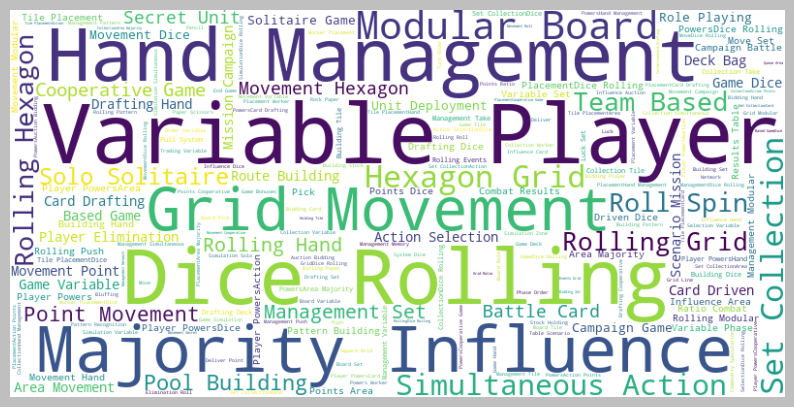

In [207]:
# Let's visualize the mechanics
# Concatenate all words into a single string
df_mechanics_words = df_org['Mechanics'].apply(clean_string)
all_words = ''.join(df_mechanics_words.str.cat(sep=''))

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words) #The bigger the word the more frequent it is
all_mechanics = wordcloud.words_
print(all_mechanics)

# Display the generated image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [208]:
# Creating dummy variables for the 'Mechanics' columns
df_mechanics = df["Mechanics"].apply(clean_string).str.get_dummies(",")
df_mechanics = df_mechanics.drop(df_mechanics.columns[-1], axis=1)

# Fixing the column names
df_mechanics.columns = [col.strip() for col in df_mechanics.columns]

# Dropping column duplicates
df_mechanics = df_mechanics.loc[:,~df_mechanics.columns.duplicated()].copy()

# Add to the main dataframe
df = pd.concat([df, df_mechanics], axis=1)

## 4.6. <a id='toc4_6_'></a>[Correlation Heatmap and Insights](#toc0_)

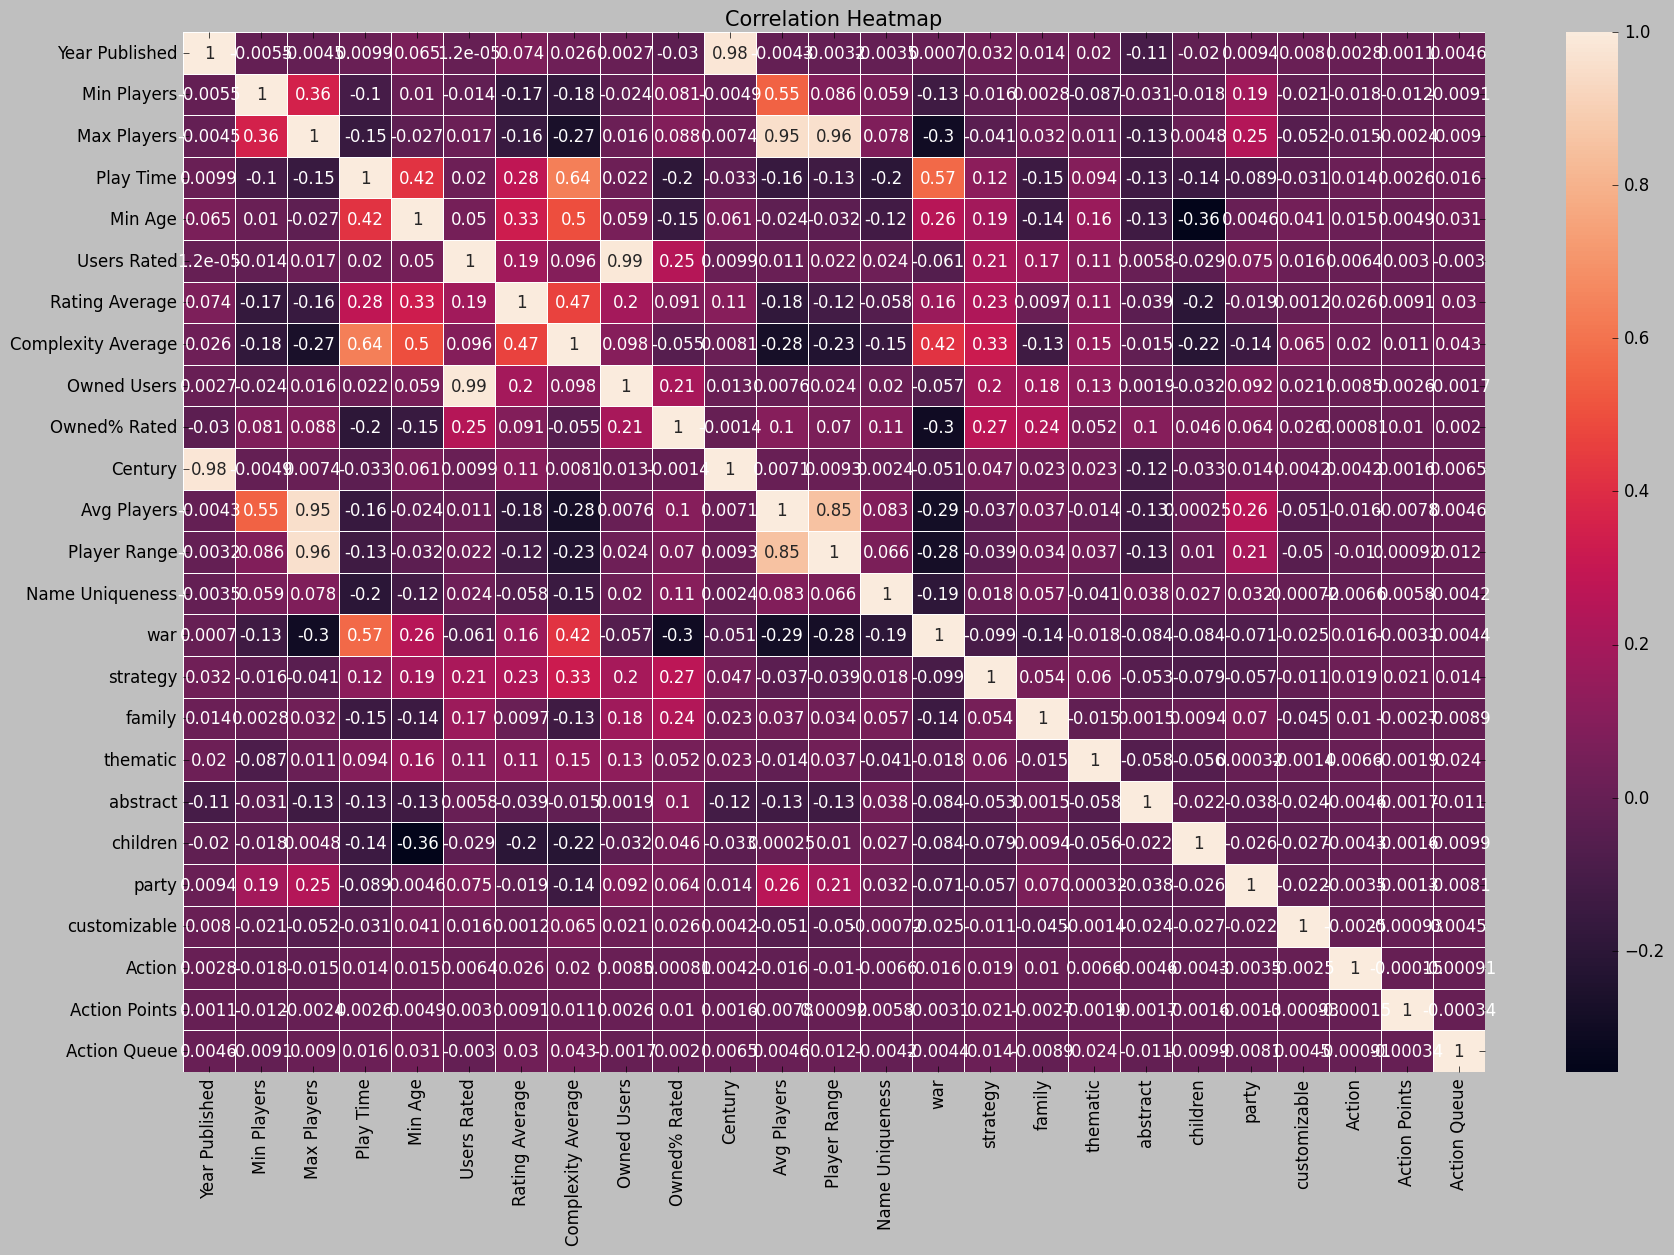

In [217]:
# Without further ado, Correlation Heatmap!

# Calculate the correlation matrix
columns = list(df.select_dtypes(include=['int64', 'float64']).columns)[:25]

corr_matrix = df[columns].corr()

# Create the heatmap
plt.figure(figsize=(21, 13))
sns.heatmap(corr_matrix, annot=True, cmap='rocket', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

**Year Published:**

Century (0.98): This is expected since Century is derived from Year Published.

**Max Players:**

Avg Players (0.95): The average number of players is closely related to the maximum number of players.
Player Range (0.96): The range of players is strongly related to the maximum number of players.
Complexity Average (-0.27): Games that support more players tend to be less complex.
war (-0.30): War games tend to support fewer players.


**Play Time:**

Complexity Average (0.64): More complex games tend to have longer play times.
Min Age (0.42): Games with longer play times are designed for older players.
war (0.57): War games tend to have longer play times.
rating avrage (0.28): Games with longer play times can have higher ratings.

**Min Age:**

Complexity Average (0.50): Games designed for older players tend to be more complex.
Children (-0.36): make perfect sense since, games designed for younger children tend to have lower minimum age requirements.


**Users Rated:**

Owned Users (0.99): The number of users who rated a game is almost identical to the number of users who own the game.
strategy (0.21): Strategy games tend to have more users rating them.

**Rating Average:**

Complexity Average (0.47): More complex games tend to have higher ratings.
Strategy (0.23): Strategy games tend to have higher ratings.

**Complexity Average:**

Play Time (0.64): More complex games tend to have longer play times.
Min Age (0.50): Games designed for older players tend to be more complex.
strategy: (0.33): Strategy games tend to be more complex.

**Owned Users:**

Users Rated (0.99): The number of users who own a game is almost identical to the number of users who rated the game.
strategy (0.27): Strategy games tend to have a higher percentage of owned users who rated them.
family (0.24): Family games tend to have a higher percentage of owned users who rated them.



***Interesting Correlations***

- **(Party & Min Players)**

  Which makes sense the higher the number of Min Players, the more 'party' it is,

  Exactly as the saying "The more the merrier" goes.

---

- **(Party & Complexity Average)**

  This is an interesting one, because it makes sense, the more complex the game

  is the less likly it is fun for a party setting.

---

- **(Children & Min Age)** and **(Children & Complexity Average)**
  
  These two are intuitive, the `Min Age` is lower in case of children games and

  the games are less complex.

  And what is more intuitve is that **(Min Age & Complexity Average)** correlate too.

---

- **(Children & Rating Average)**

  This one is tricky because it could mean a lot of things:

  - Children give bad reviews and the games are bad
  - Or if the parents are the one reviewing then the review is not based on the point of view of the player which could mean there is some kind of bias.


---

- **(Abstract & Min Age)**

  The higher the `Min Age` the more abstract the game is and vice versa.

---

- **(Abstract & (Century or Year Published))**

  This one could mean that older games are less abstract.

---


- **(Owned% Rated & (Abstract or Family or Strategy))**

  These domains seem to be worth reviewing and that does not mean that the reviews are good but there seem to be a lot of opinions on a game that has these domains.

---

- **(Owned% Rated & War)**

  For some reason, war games lack reviews, it would have made sense if war was brought to the reviews as well and not just in the game.

---

- **(Complexity Average & Rating Average)**

 Complex games are better?

---

- **(Complexity Average & (War or Strategy))**

 War is complex, quite a fair point.

 ---

- **(Play Time & (War or Complexity Average))**

 War is complex und takes time!

- **Name Uniqueness**

  Interestingly, the frequancies of the words that make up the game name, correlate with, `War`, `Complexity Average`, `Min Age`, and `Owned% Rated`

# 5. <a id='toc5_'></a>[Model Selection](#toc0_)

In [27]:
def compare_metrics(y_true:pd.DataFrame, y_pred:pd.DataFrame) -> dict:
    # Calculate metrics
    scores={}
    scores['MAE'] = mean_absolute_error(y_true, y_pred)
    scores['MSE'] = mean_squared_error(y_true, y_pred)
    scores['RMSE'] = root_mean_squared_error(y_true, y_pred)
    scores['R2'] = r2_score(y_true, y_pred)

    return scores

## 5.1. <a id='toc5_1_'></a>[Training and Test Data Split](#toc0_)

In [28]:
print(df.columns[:20])

Index(['Name', 'Year Published', 'Min Players', 'Max Players', 'Play Time',
       'Min Age', 'Users Rated', 'Rating Average', 'Complexity Average',
       'Owned Users', 'Mechanics', 'Domains', 'Owned% Rated', 'Century',
       'Name Uniqueness', 'war', 'strategy', 'family', 'thematic', 'abstract'],
      dtype='object')


In [29]:
y = df["Rating Average"]

drop_columns = ['Name', 'Year Published', 'Users Rated','Owned Users', 'Domains', 'Mechanics', 'Rating Average']
X = df.drop(columns=drop_columns)
X = X.astype(np.float32)

In [30]:
display(X.info())
display(X.describe())
display(X.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17652 entries, 0 to 17651
Columns: 210 entries, Min Players to Push
dtypes: float32(210)
memory usage: 14.1 MB


None

,Min Players,Max Players,Play Time,Min Age,Complexity Average,Owned% Rated,Century,Name Uniqueness,war,strategy,...,Victory Points as a Resource,Voting,Worker Placement,Worker Placement with Dice Workers,Zone of Control,Acting,Action Drafting,Bidding,Event,Push
count,17652.00,17652.00,17652.00,17652.00,17652.00,17652.00,17652.00,17652.00,17652.00,17652.00,...,17652.00,17652.00,17652.00,17652.00,17652.00,17652.00,17652.00,17652.00,17652.00,17652.00
mean,2.02,4.75,67.37,10.21,1.97,46.91,1965.94,0.53,0.14,0.12,...,0.00,0.02,0.04,0.00,0.01,0.01,0.00,0.05,0.00,0.00
std,0.65,2.36,66.81,2.76,0.81,17.34,163.08,0.62,0.35,0.32,...,0.05,0.13,0.19,0.05,0.09,0.10,0.04,0.23,0.04,0.03
min,1.00,1.00,1.00,1.00,0.00,2.00,-3500.00,-4.29,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,2.00,4.00,30.00,8.00,1.33,34.29,2000.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,2.00,4.00,45.00,10.00,1.93,44.86,2000.00,0.90,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,2.00,6.00,90.00,12.00,2.50,57.65,2000.00,1.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,9.00,20.00,360.00,25.00,5.00,99.72,2000.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


,Min Players,Max Players,Play Time,Min Age,Complexity Average,Owned% Rated,Century,Name Uniqueness,war,strategy,...,Victory Points as a Resource,Voting,Worker Placement,Worker Placement with Dice Workers,Zone of Control,Acting,Action Drafting,Bidding,Event,Push
0,1.00,4.00,120.00,14.00,3.86,61.55,2000.00,0.00,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,2.00,4.00,60.00,13.00,2.84,63.78,2000.00,0.75,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,2.00,4.00,120.00,14.00,3.91,66.76,2000.00,1.00,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,1.00,5.00,120.00,12.00,3.24,74.47,2000.00,1.00,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,1.00,4.00,120.00,14.00,3.55,38.84,2000.00,-0.77,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [31]:
display(y.info())
display(y.describe())
display(y.head())

<class 'pandas.core.series.Series'>
RangeIndex: 17652 entries, 0 to 17651
Series name: Rating Average
Non-Null Count  Dtype  
--------------  -----  
17652 non-null  float64
dtypes: float64(1)
memory usage: 138.0 KB


None

count   17652.00
mean        6.39
std         0.89
min         1.90
25%         5.82
50%         6.41
75%         6.98
max         9.46
Name: Rating Average, dtype: float64

0   8.79
1   8.61
2   8.66
3   8.43
4   8.87
Name: Rating Average, dtype: float64

In [32]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED)

## 5.2. <a id='toc5_2_'></a>[LazyPredict](#toc0_)

In [33]:
reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None, random_state=SEED)
models, predictions = reg.fit(X_train, X_val, y_train, y_val)

100%|██████████| 42/42 [03:33<00:00,  5.08s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003715 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1196
[LightGBM] [Info] Number of data points in the train set: 14121, number of used features: 117
[LightGBM] [Info] Start training from score 6.382825


In [34]:
# It seems that boosting models perform better.
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
LGBMRegressor,0.43,0.47,0.64,0.23
HistGradientBoostingRegressor,0.43,0.47,0.64,1.05
ExtraTreesRegressor,0.41,0.44,0.65,9.91
RandomForestRegressor,0.40,0.44,0.65,10.95
GradientBoostingRegressor,0.40,0.44,0.65,3.13
SVR,0.37,0.41,0.67,17.32
NuSVR,0.37,0.40,0.67,16.24
BaggingRegressor,0.35,0.39,0.68,1.05
HuberRegressor,0.33,0.37,0.69,1.39


In [35]:
# Save DataFrame for future reference
models.to_csv('models/models.csv') 

## 5.3. <a id='toc5_3_'></a>[Grid Searches](#toc0_)

### 5.3.1. <a id='toc5_3_1_'></a>[RandomForestRegressor](#toc0_)

In [ ]:
# GridSearchCV on RandomForestRegressor
param_grid_rf = {
    'n_estimators': [100, 200, 250, 300],
    'max_features':[0.5, 0.7, 0.9],
    'min_samples_split': [8, 16, 32],
    'min_samples_leaf': [2, 4, 8, 16]
}

# Create a GridSearchCV object
grid_search_rf = GridSearchCV(estimator=RandomForestRegressor(random_state=SEED),
                              param_grid=param_grid_rf,
                              scoring='r2',
                              cv=3,
                              n_jobs=-1,
                              verbose=4
                              )


# Fit the GridSearchCV object to the training data
grid_search_rf.fit(X_train, y_train)

# print the best score and parameters
print(f"Best score: {grid_search_rf.best_score_:.3f}")
print(f"Best parameters: {grid_search_rf.best_params_}")
rf_reg = grid_search_rf.best_estimator_

In [ ]:
# Test performance on val set
y_pred_rf = rf_reg.predict(X_val)
compare_metrics(y_val, y_pred_rf)

In [ ]:
# Save model for future reference 
joblib.dump(grid_search_rf, "models/grid_search_rf.pkl", compress=3)
joblib.dump(rf_reg, "models/rf_reg.pkl", compress=3)

### 5.3.2. <a id='toc5_3_2_'></a>[CatBoost Regressor](#toc0_)

In [ ]:
params_cb = {
    'learning_rate': [0.05, 0.07, 0.09, 0.12],
    'depth': [None, 6, 8, 10],
    'iterations': [100, 500, 750, 1000],
    'loss_function': ['RMSE'],
    'eval_metric': ['RMSE'],
    'task_type': ['CPU'],
    'verbose':[0]
}

grid_search_cb = GridSearchCV(CatBoostRegressor(random_state=SEED),
                    params_cb,
                    scoring='r2',
                    cv=3,
                    n_jobs=-1,
                    verbose=4
                    )

grid_search_cb.fit(X_train, y_train)

# print the best score and parameters
print(f"Best score: {grid_search_cb.best_score_:.3f}")
print(f"Best parameters: {grid_search_cb.best_params_}")
cb_reg = grid_search_cb.best_estimator_

In [ ]:
y_pred_cb = cb_reg.predict(X_val)
compare_metrics(y_val, y_pred_cb)

In [ ]:
# Save model for future reference 
joblib.dump(grid_search_cb, "models/grid_search_cb.pkl", compress=3)
joblib.dump(cb_reg, "models/cb_reg.pkl", compress=3)

### 5.3.3. <a id='toc5_3_3_'></a>[LGBMRegressor](#toc0_)

In [ ]:
params_gbm = {
    'num_leaves': [8, 16, 32, 64],
    'learning_rate': [0.07, 0.09, 0.1],
    'max_depth': [-1, 3, 5],
    'n_estimators': [50, 100, 200, 500],
}

# LGBM hates some column names, we fix all of them by removing all special chars.
X_train_gbm = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_val_gbm = X_val.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

# Perform grid search
grid_search_gbm = GridSearchCV(lgb.LGBMRegressor(random_state=SEED),
                    params_gbm,
                    scoring='r2',
                    cv=3,
                    n_jobs=-1,
                    verbose=4
                    )

grid_search_gbm.fit(X_train_gbm, y_train)

# print the best score and parameters
print(f"Best score: {grid_search_gbm.best_score_:.3f}")
print(f"Best parameters: {grid_search_gbm.best_params_}")
gbm_reg = grid_search_gbm.best_estimator_

In [ ]:
y_pred_gbm = gbm_reg.predict(X_val_gbm)
compare_metrics(y_val, y_pred_gbm)

In [ ]:
# Save model for future reference 
joblib.dump(grid_search_gbm, "models/grid_search_gbm.pkl", compress=3)
joblib.dump(gbm_reg, "models/gbm_reg.pkl", compress=3)

### 5.3.4. <a id='toc5_3_4_'></a>[HistGradientBoostingRegressor](#toc0_)

In [ ]:
param_grid_hgb = {
    'learning_rate': [0.1, 0.15, 0.07],
    'max_iter': [50, 100, 200, 300, 400, 500],
    'max_leaf_nodes': [8, 16, 32]
}

# Perform grid search
grid_search_hgb = GridSearchCV(estimator=HistGradientBoostingRegressor(random_state=SEED),
                            param_grid=param_grid_hgb,
                            scoring='r2',
                            cv=3,
                            n_jobs=-1,
                            verbose=4
                          )

grid_search_hgb.fit(X_train, y_train)

# print the best score and parameters
print(f"Best score: {grid_search_hgb.best_score_:.3f}")
print(f"Best parameters: {grid_search_hgb.best_params_}")
hgb_reg = grid_search_hgb.best_estimator_

In [ ]:
y_pred_hgb = hgb_reg.predict(X_val)
compare_metrics(y_val, y_pred_hgb)

In [ ]:
# Save model for future reference 
joblib.dump(grid_search_hgb, "models/grid_search_hgb.pkl", compress=3)
joblib.dump(hgb_reg, "models/hgb_reg.pkl", compress=3)

### 5.3.5. <a id='toc5_3_5_'></a>[Weighted Average Model](#toc0_)

In [ ]:
# We assign weights based on the training scores
y_pred = y_pred_rf*0.2 + y_pred_cb*0.2 + y_pred_hgb*0.3 ### + y_pred_gbm*0.3
compare_metrics(y_val, y_pred)

## 5.4. <a id='toc5_4_'></a>[Metrics and Weighted Average from Loaded Models](#toc0_)

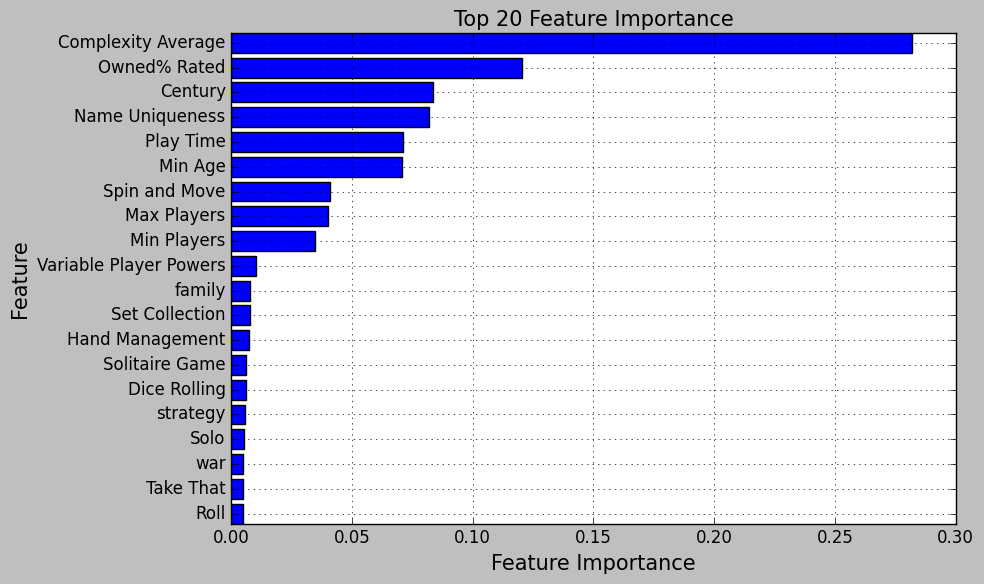

In [36]:
# Load model
rf_reg_loaded = joblib.load("models/rf_reg.pkl")

# Let's look at the top 20 features
feature_importances = rf_reg_loaded.feature_importances_
feature_names = X.columns
top_20_indices = np.argsort(feature_importances)[-20:]

# Sort feature importances and names in descending order
sorted_importances = feature_importances[top_20_indices]
sorted_names = np.array(feature_names)[top_20_indices]

# Create bar plot
plt.figure(figsize=(10, 6))
plt.barh(sorted_names, sorted_importances)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 20 Feature Importance")
plt.grid();plt.tight_layout()
plt.show()

In [37]:
rf_reg_loaded = joblib.load("models/rf_reg.pkl")
y_pred_rf_loaded = rf_reg_loaded.predict(X_val)
print("y_pred_rf_loaded:", compare_metrics(y_val, y_pred_rf_loaded), sep="\n")

cb_reg_loaded = joblib.load("models/cb_reg.pkl")
y_pred_cb_loaded = cb_reg_loaded.predict(X_val)
print("y_pred_cb_loaded:", compare_metrics(y_val, y_pred_cb_loaded), sep="\n")

### gbm_reg_loaded = joblib.load("models/gbm_reg.pkl")
### y_pred_gbm_loaded = gbm_reg_loaded.predict(X_val)
### print("y_pred_gbm_loaded:", compare_metrics(y_val, y_pred_gbm_loaded), sep="\n")

hgb_reg_loaded = joblib.load("models/hgb_reg.pkl")
y_pred_hgb_loaded = hgb_reg_loaded.predict(X_val)
print("y_pred_hgb_loaded:", compare_metrics(y_val, y_pred_hgb_loaded), sep="\n")

y_pred_loaded = y_pred_rf_loaded*0.2 + y_pred_cb_loaded*0.2 + y_pred_hgb_loaded*0.3 ### + y_pred_gbm_loaded*0.3
print("y_pred_loaded:", compare_metrics(y_val, y_pred_loaded), sep="\n")


y_pred_rf_loaded:
{'MAE': 0.49144779523324333, 'MSE': 0.41203560510628834, 'RMSE': 0.6418999961881043, 'R2': 0.4591520974699501}
y_pred_cb_loaded:
{'MAE': 0.4798678792850467, 'MSE': 0.397105559768584, 'RMSE': 0.6301631215555097, 'R2': 0.47874963614259214}
y_pred_hgb_loaded:
{'MAE': 0.4864761784800983, 'MSE': 0.4059341260631388, 'RMSE': 0.6371295991108393, 'R2': 0.4671610464586359}
y_pred_loaded:
{'MAE': 1.93255405489039, 'MSE': 4.1533912169567575, 'RMSE': 2.0379870502426547, 'R2': -4.451841783183582}
